<a href="https://colab.research.google.com/github/adamzbikowski/Process-Mining-Dissertation/blob/main/activity_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pipeline 1: predicting missing values for activity

##Section 0: Customisation

**Note on usage:**
To customise the pipeline, only alter the parameters in this section.

In [1]:
# The following parameters can be customised:

# change depending on which branch the queries have been pushed to
BRANCH = "sql-queries" 

# change this to change which query is being used
QUERY_NAME = "el_hypertension.sql"
# QUERY_NAME = "el_diabetes.sql"
# QUERY_NAME = "el_congestive_heart_failure.sql"
# QUERY_NAME = "el_kidney_failure.sql"
# QUERY_NAME = "el_artial_fibrillation.sql"

# this assumes that the user has access to the mimic-iii dataset
# through google BigQuery
# replace project name to the project containing mimic-iii
PROJECT_NAME = "processmining-367815" 

# change to alter the number of random traces being selected
# set value to None in order to use the full dataset
NUM_TRACES = 10000

# IGNORE if event log does not include procedures
# set to false if  
CATEGORICAL_PROCEDURES = False

# change to alter the prefix/suffix length
PREFIX_LENGTH = 5

# change to alter the size of the test and validation sets
TEST_SIZE = 0.2
VALIDATION_SIZE = 0.2

## Section 1: Loading event log

###1.1

In [2]:
# installing prerequisites
# certain packages are not installed by default on google colab
!pip install pm4py
!pip install -q -U keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 14.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26114 sha256=a3f28ea2930b1efcefd20b8f0c006a8162218e799937abaa0c16499120d1f01d
  Stored in directory: /root/.cache/pip/wheels/fa/80/8c/43488a924a046b733b64de3fac99252674c892a4c3801c0a61
  Created wheel for stringdist: filename=StringDist-1.0.9-cp310-cp310-linux_x86_64.whl size=24953 sha256=6ab45f38fb0b80a147dd1729567482cb68c0ad6a50e8874a6c4b0f636371c578
  Stored in directory: /root/.cache/pip/wheels/79/25/0a/4a0c2c7af31a8b473f6e10e30312396f31ae899722600d7b99
Successfully built intervaltree stringdist
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 3.7 MB/s eta 0:00:00


In [3]:
# sign in to google account linked to physionet
from google.colab import auth
auth.authenticate_user()

In [4]:
# connect to BigQuery
from google.cloud import bigquery
client = bigquery.Client(project=PROJECT_NAME)

In [5]:
import requests

# read a query from the github repository
url = f"https://raw.githubusercontent.com/adamzbikowski/Process-Mining-Dissertation/{BRANCH}/sql_queries/{QUERY_NAME}"
query_bytes = requests.get(url).content

# we must now decode this to turn the query into a string 
query = query_bytes.decode("utf-8")

###1.2

In [6]:
import pandas as pd

# loading event log from mimic-iii using bigQuery
event_log = client.query(query).to_dataframe()
# convert timestamp from object to datetime64
event_log["timestamp"] = pd.to_datetime(event_log["timestamp"])
event_log


,patient,activity,timestamp
0,120290,Dialysis,2201-02-09 01:41:00
1,120290,Dialysis,2201-02-13 22:31:00
2,136056,Dialysis,2190-02-16 10:30:00
3,136056,Dialysis,2190-02-11 18:35:00
4,136056,Dialysis,2190-02-13 20:30:00
...,...,...,...
127266,116847,IV,2195-03-05 18:31:00
127267,155516,IV,2103-09-21 03:00:00
127268,177751,IV,2189-02-09 20:00:00
127269,121528,IV,2174-04-12 15:55:00


## Section 2: Process Discovery

In [7]:
import pm4py as pm

event_log = pm.format_dataframe(event_log, case_id='patient', activity_key='activity', timestamp_key='timestamp')
# lets get some information about the event log
n_events = len(event_log)
n_cases = len(event_log.patient.unique())
start_events = pm.get_start_activities(event_log)
end_events = pm.get_end_activities(event_log)
print(f"Number of cases: {n_cases}\nNumber of events: {n_events}")
print(f"Start events: {start_events}\nEnd events: {end_events}")


<ipython-input-7-aedec179434f>:3: DeprecatedWarning: format_dataframe is deprecated as of 2.3.0 and will be removed in 3.0.0. the format_dataframe function does not need application anymore.
  event_log = pm.format_dataframe(event_log, case_id='patient', activity_key='activity', timestamp_key='timestamp')


Number of cases: 20696
Number of events: 127271
Start events: {'Admitted': 20390, 'Entered ICU': 265, 'Discharged': 23, 'Ventilation': 18}
End events: {'Discharged': 17501, 'Left ICU': 3193, 'Admitted': 2}


In [8]:
# lets improve the event log by filtering out the cases that do not start or end with a patient being admitted or discharged
# this will simplify the model
event_log = pm.filter_start_activities(event_log, ['Admitted'])
event_log = pm.filter_end_activities(event_log,['Discharged'])

In [9]:
# lets recalculate the number of traces
n_events = len(event_log)
n_cases = len(event_log.patient.unique())
start_events = pm.get_start_activities(event_log)
end_events = pm.get_end_activities(event_log)
print(f"Number of cases: {n_cases}\nNumber of events: {n_events}")
print(f"Start events: {start_events}\nEnd events: {end_events}")

Number of cases: 17237
Number of events: 103017
Start events: {'Admitted': 17237}
End events: {'Discharged': 17237}


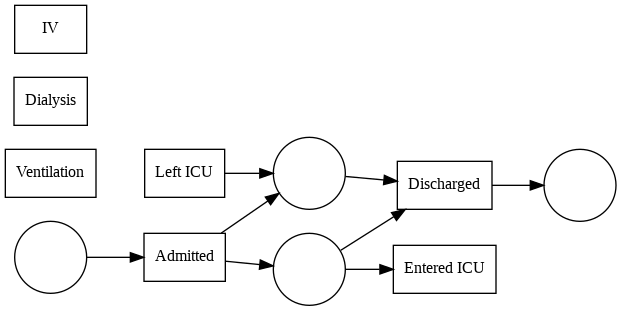

In [10]:
# create petri net using alpha miner
import graphviz
net, initial_marking, final_marking = pm.discover_petri_net_alpha(event_log)
pm.view_petri_net(petri_net=net)

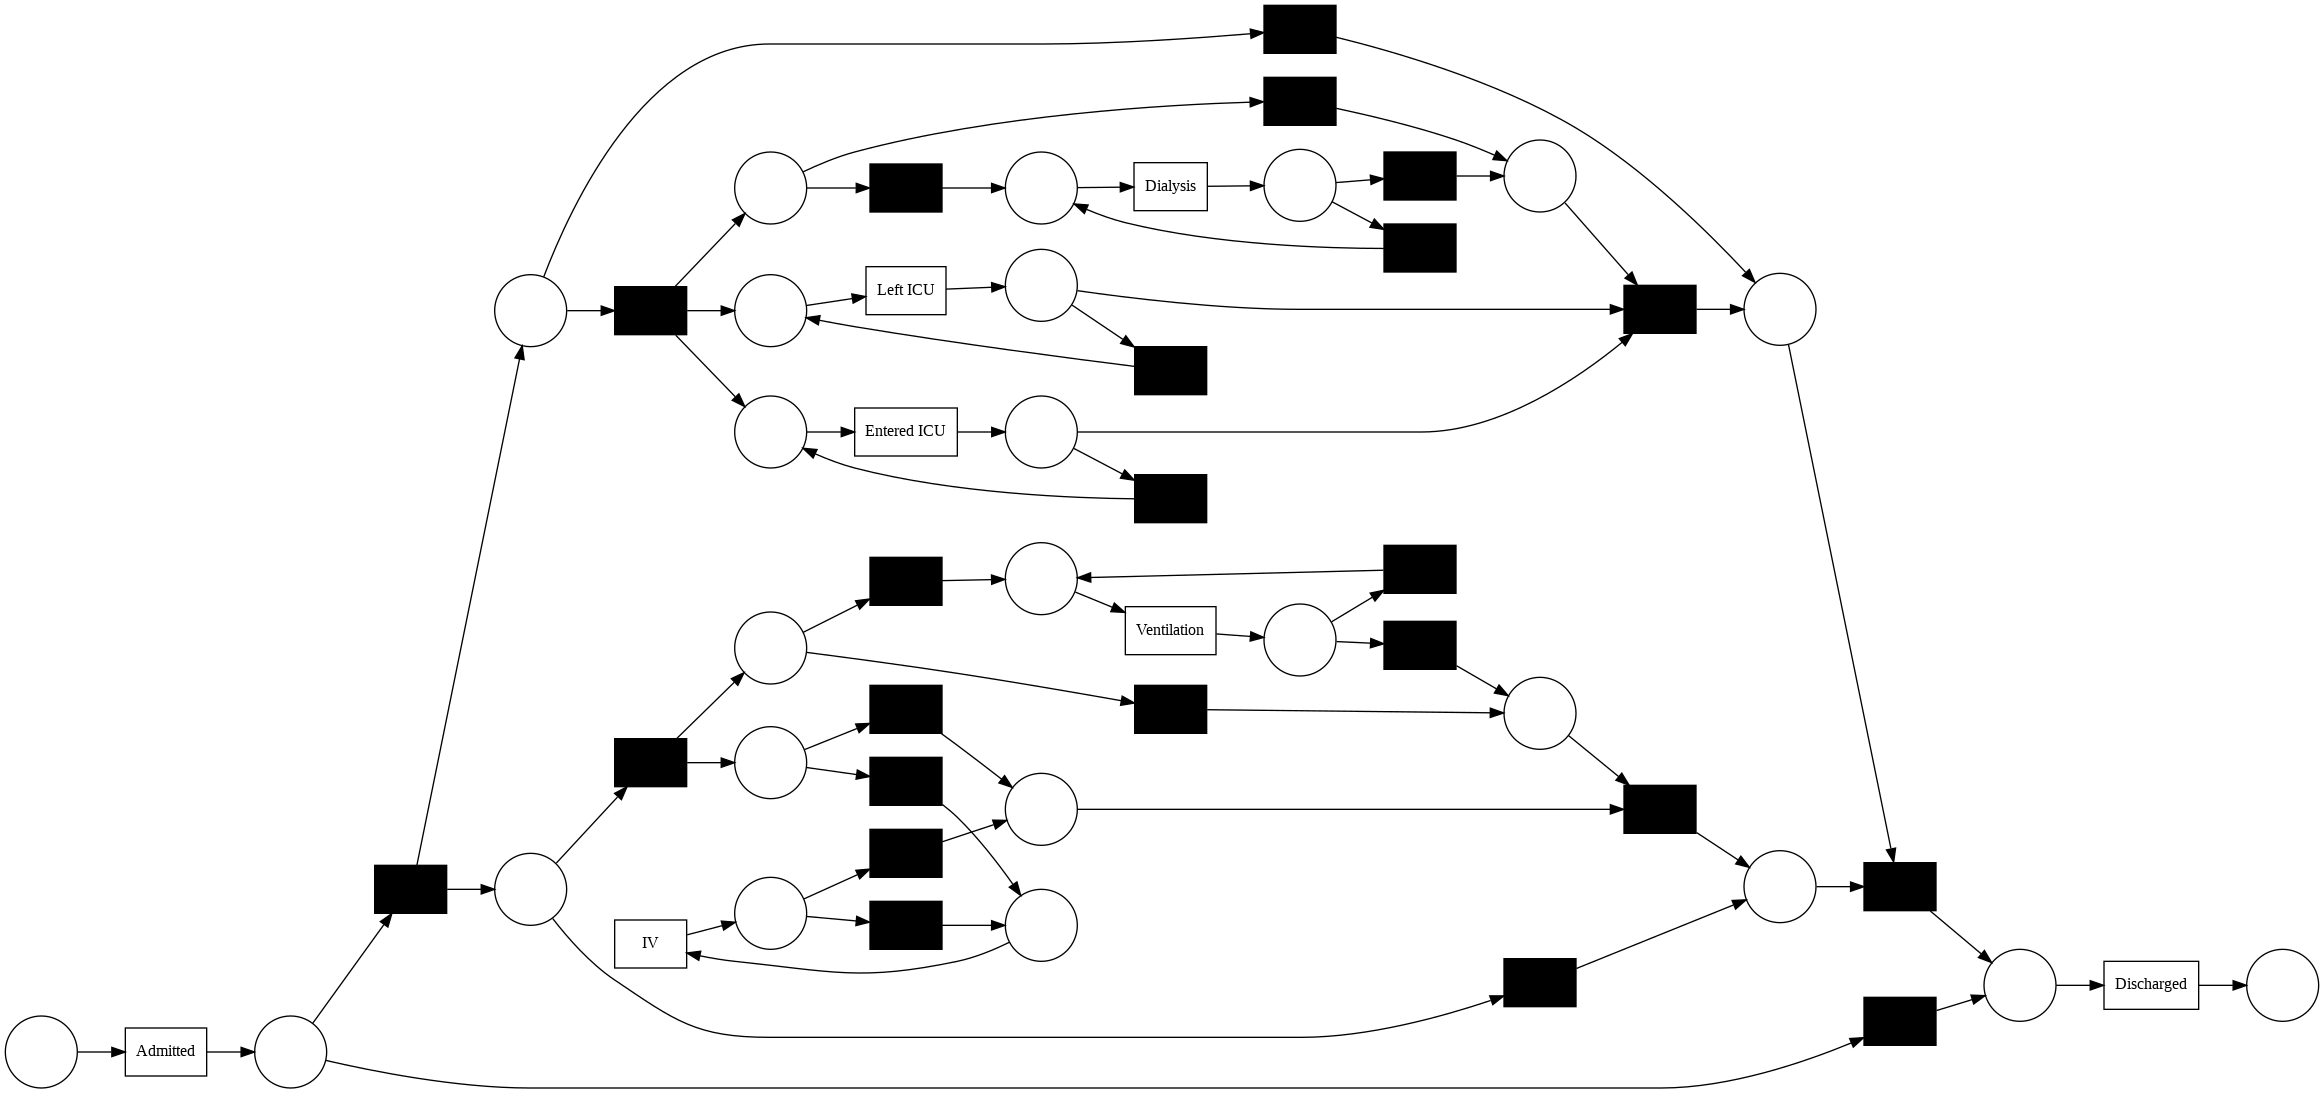

In [11]:
# inductive miner
# much better result than when using alpha miner
net, initial_marking, final_marking = pm.discover_petri_net_inductive(event_log)
pm.view_petri_net(petri_net=net)

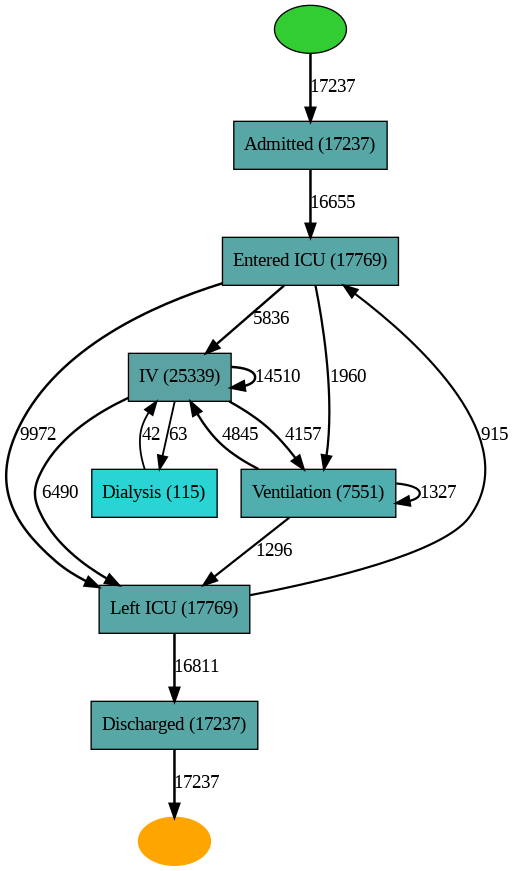

In [12]:
# heuristic miner
heu_net = pm.discover_heuristics_net(event_log, dependency_threshold=0.99)
pm.view_heuristics_net(heu_net)

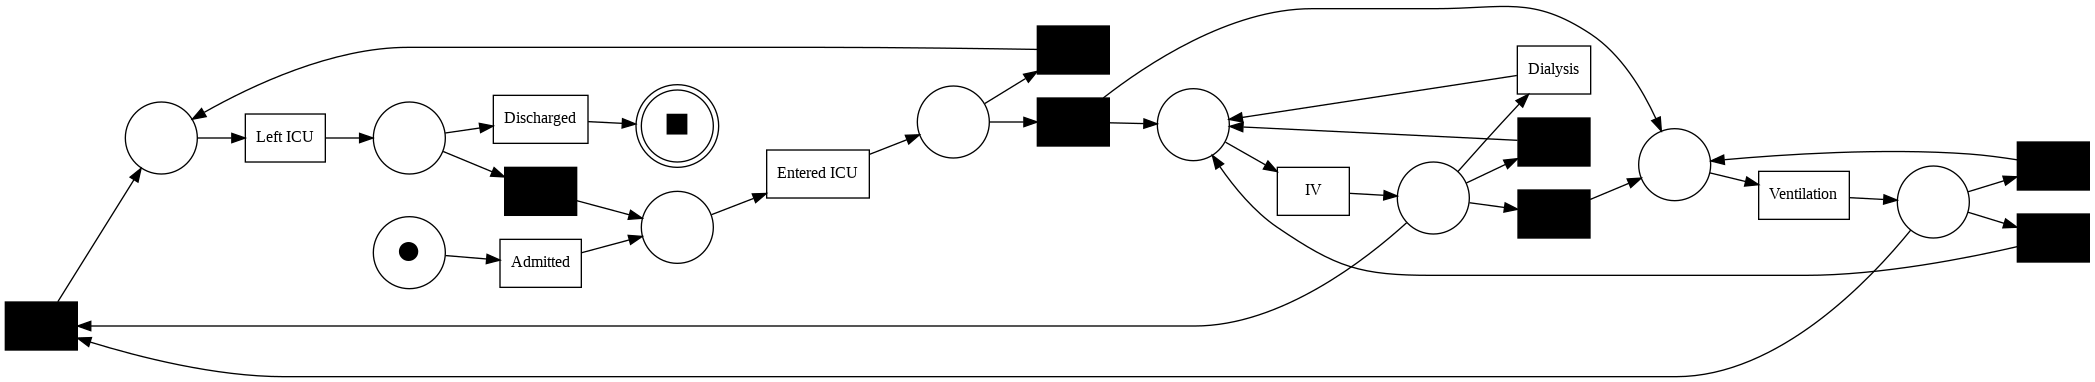

In [13]:
# petri net from heuristics miner
net, im, fm = pm.discover_petri_net_heuristics(event_log, dependency_threshold=0.99)
pm.view_petri_net(net, im, fm)

In [14]:
# apply alignments to test conformance
def replay(el, pn, im, fm):
  replay_result_alignments = pm.fitness_alignments(el, pn, im, fm)
  return  replay_result_alignments['average_trace_fitness']

In [15]:
replay(event_log, net, im, fm)

aligning log, completed variants ::   0%|          | 0/1046 [00:00<?, ?it/s]

0.9674622768313287

## Section 3: Data Pre Processing



In [16]:
from pandas.core.window.ewm import partial
import random

# function selects n cases from event log
# returns a subset of the event log
def partial_log(el, n):

  # select the first n cases to test the LSTM methodology
  # lets first add a trace column to the event_log
  el['trace'] = el.groupby(['patient']).ngroup()
  el = el[['trace', 'activity', 'timestamp' ]].reset_index(drop=True)
  # if n is None, return full event log
  if n is None:
    return el

  # initialise random seed and array of traces
  random.seed(9)
  random_traces = []

  for i in range(0,n):
    random_traces.append(random.randrange(0,n_cases))

  partial_el = event_log[event_log['trace'].isin(random_traces)]
  return partial_el


In [17]:
partial_el = partial_log(event_log, NUM_TRACES)
partial_el

,patient,activity,timestamp,case:concept:name,concept:name,time:timestamp,@@index,@@case_index,start_timestamp,trace
20,100012,Admitted,2177-03-12 11:48:00,100012,Admitted,2177-03-12 11:48:00,20,3,2177-03-12 11:48:00,3
21,100012,Entered ICU,2177-03-14 10:52:23,100012,Entered ICU,2177-03-14 10:52:23,21,3,2177-03-14 10:52:23,3
22,100012,Ventilation,2177-03-14 12:30:00,100012,Ventilation,2177-03-14 12:30:00,22,3,2177-03-14 12:30:00,3
23,100012,IV,2177-03-14 12:30:00,100012,IV,2177-03-14 12:30:00,23,3,2177-03-14 12:30:00,3
24,100012,Ventilation,2177-03-14 16:10:00,100012,Ventilation,2177-03-14 16:10:00,24,3,2177-03-14 16:10:00,3
...,...,...,...,...,...,...,...,...,...,...
127257,199979,Discharged,2182-02-10 14:50:00,199979,Discharged,2182-02-10 14:50:00,127257,20692,2182-02-10 14:50:00,17233
127263,199986,Admitted,2188-10-30 16:55:00,199986,Admitted,2188-10-30 16:55:00,127263,20694,2188-10-30 16:55:00,17235
127264,199986,Entered ICU,2188-10-30 16:55:35,199986,Entered ICU,2188-10-30 16:55:35,127264,20694,2188-10-30 16:55:35,17235
127265,199986,Left ICU,2188-10-31 16:14:16,199986,Left ICU,2188-10-31 16:14:16,127265,20694,2188-10-31 16:14:16,17235


In [18]:

# lets represent each activity using a statically defined number
# this will prevent the need for using an embedding layer when traing the LSTM
unique_activities = partial_el['activity'].unique()
n_activities = len(unique_activities) + 1
encode_activity = {unique_activities[i-1] : f'{i}' for i in range(1,n_activities)}

# lets also create a second dictionary that will be used to decode predicted activities
decode_activity = {f'{i}' : unique_activities[i-1] for i in range(1, len(unique_activities)+ 1)}

encode_activity, decode_activity

({'Admitted': '1',
  'Entered ICU': '2',
  'Ventilation': '3',
  'IV': '4',
  'Left ICU': '5',
  'Discharged': '6',
  'Dialysis': '7'},
 {'1': 'Admitted',
  '2': 'Entered ICU',
  '3': 'Ventilation',
  '4': 'IV',
  '5': 'Left ICU',
  '6': 'Discharged',
  '7': 'Dialysis'})

In [19]:
from sklearn.model_selection import train_test_split
# select train and test traces
unique_traces = partial_el['trace'].unique()
train_traces, test_traces = train_test_split(unique_traces, test_size=TEST_SIZE, random_state=9)

# split event log using train and test traces
train_el = partial_el.loc[partial_el['trace'].isin(train_traces)]
test_el = partial_el.loc[partial_el['trace'].isin(test_traces)]

In [22]:
# calculate time deltas for prefix and suffix sequences
def calculate_time_deltas(p, s):
  p_deltas, s_deltas = [], []
  f = '%Y-%d-%m %H:%M:%S'
  for i in range(PREFIX_LENGTH):
    if p[i] == '0' or p[i+1] == '0':
      p_deltas.append(0)

    else:
      delta = pd.to_datetime(p[i+1], format=f) - pd.to_datetime(p[i], format=f)
      p_deltas.append(delta.total_seconds())

  for i in range(PREFIX_LENGTH,0,-1):
    if s[i] == '0' or s[i-1] == '0':
      s_deltas.append(0)
    else:
      delta = pd.to_datetime(s[i], format=f) - pd.to_datetime(s[i-1], format=f)
      s_deltas.append(delta.total_seconds())
  
  return p_deltas, s_deltas[::-1]

In [20]:
import numpy as np

# create a new labeled data frame
def label(el):
  # initialise data frame and lists
  prefix_arr, suffix_arr, prefix_times_arr, suffix_times_arr, label_arr = [], [], [], [], []
  labeled_arr = []
  unique_traces = el['trace'].unique()
  traces = {x : pd.DataFrame() for x in unique_traces} 

  for t in unique_traces:
    traces[t] = el[:][el.trace == t]  
  
  for t in unique_traces:
    # sort trace chronologically
    df = traces[t].sort_values(by='timestamp')
    activities, timestamps = [], []

    for i in df.index:
      activity = encode_activity.get(df['activity'][i])
      activities.append(activity)

      timestamp = df['timestamp'][i]
      timestamps.append(timestamp)

    
    length = len(activities)

    # for each event, find prefix and suffix sequences
    for i in range(length):

      label = activities[i]
      prefix = activities[:i]
      prefix_times = timestamps[:i+1]

      suffix = []
      suffix_times = []

      if i != length - 1:
        suffix = activities[i+1:]

      if i != length:
        suffix_times = timestamps[i:]

      padding = []

      while len(prefix) + len(padding) < PREFIX_LENGTH:
        padding.append('0')
      
      prefix = padding + prefix
        
      padding = []
      
      while len(prefix_times) + len(padding) < PREFIX_LENGTH+1:
        padding.append('0')
      
      prefix_times =  padding + prefix_times

      while len(suffix) < PREFIX_LENGTH:
        suffix.append('0')

      while len(suffix_times) < PREFIX_LENGTH +1:
        suffix_times.append('0')

      prefix_deltas, suffix_deltas = calculate_time_deltas(prefix_times, suffix_times)

      prefix_arr.append(np.array(prefix[0:PREFIX_LENGTH], dtype=int))
      suffix_arr.append(np.array(suffix[0:PREFIX_LENGTH], dtype=int))
      prefix_times_arr.append(np.array(prefix_deltas))
      suffix_times_arr.append(np.array(suffix_deltas))
      label_arr.append(label)

  return pd.DataFrame({'prefix' : prefix_arr, 
                       'suffix' : suffix_arr,
                       'prefix time delta' : prefix_times_arr,
                       'suffix time delta' : suffix_times_arr,
                       'label' : label_arr})
 

In [23]:
labeled_train = label(train_el)
labeled_train

,prefix,suffix,prefix time delta,suffix time delta,label
0,"[0, 0, 0, 0, 0]","[2, 3, 4, 3, 3]","[0, 0, 0, 0, 0]","[169463.0, 5857.0, 0.0, 13200.0, 62400.0]",1
1,"[0, 0, 0, 0, 1]","[3, 4, 3, 3, 3]","[0.0, 0.0, 0.0, 0.0, 169463.0]","[5857.0, 0.0, 13200.0, 62400.0, 17400.0]",2
2,"[0, 0, 0, 1, 2]","[4, 3, 3, 3, 5]","[0.0, 0.0, 0.0, 169463.0, 5857.0]","[0.0, 13200.0, 62400.0, 17400.0, 210135.0]",3
3,"[0, 0, 1, 2, 3]","[3, 3, 3, 5, 6]","[0.0, 0.0, 169463.0, 5857.0, 0.0]","[13200.0, 62400.0, 17400.0, 210135.0, 395265.0]",4
4,"[0, 1, 2, 3, 4]","[3, 3, 5, 6, 0]","[0.0, 169463.0, 5857.0, 0.0, 13200.0]","[62400.0, 17400.0, 210135.0, 395265.0, 0.0]",3
...,...,...,...,...,...
36308,"[1, 2, 3, 4, 4]","[0, 0, 0, 0, 0]","[115553.0, 13447.0, 5700.0, 60.0, 60.0]","[0, 0, 0, 0, 0]",6
36309,"[0, 0, 0, 0, 0]","[2, 5, 6, 0, 0]","[0, 0, 0, 0, 0]","[35.0, 83921.0, 159944.0, 0.0, 0.0]",1
36310,"[0, 0, 0, 0, 1]","[5, 6, 0, 0, 0]","[0.0, 0.0, 0.0, 0.0, 35.0]","[83921.0, 159944.0, 0.0, 0.0, 0.0]",2
36311,"[0, 0, 0, 1, 2]","[6, 0, 0, 0, 0]","[0.0, 0.0, 0.0, 35.0, 83921.0]","[159944.0, 0.0, 0.0, 0.0, 0.0]",5


In [24]:
from copy import deepcopy

# randomly remove one activity label in each trace
# return event log, and test targets
def random_remove(el):
  unique_traces_test = el['trace'].unique()
  traces = {x : pd.DataFrame() for x in unique_traces_test}
  df = pd.DataFrame(columns=['trace', 'activity', 'timestamp'])
  random.seed = (9)
  targets = []

  for t in unique_traces_test:
    traces[t] = deepcopy(test_el[:][test_el.trace == t])
    trace_df = traces[t].sort_values(by='timestamp')
    rand_index = random.randrange(0,len(trace_df.index))
    targets.append(trace_df.iat[rand_index,1])
    trace_df.iat[rand_index, 1] = np.nan
    df = pd.concat([df, trace_df])

  return df, targets

In [26]:
test_el, test_targets = random_remove(test_el)

In [27]:
def label_test(el):
  prefix_arr, suffix_arr, prefix_times_arr, suffix_times_arr, label_arr = [], [], [], [], []
  labeled_arr = []
  unique_traces = el['trace'].unique()

  for t in unique_traces:
    df = el[:][el.trace == t]
    activities, timestamps = [], []

    for i in df.index:
      activity = encode_activity.get(df['activity'][i])
      activities.append(activity)

      timestamp = df['timestamp'][i]
      timestamps.append(timestamp)

    length = len(timestamps)
    order = 0
    for i in range(length):
      if pd.isnull(activities[i]):
        order = i
        break

    label = activities[order]
    prefix = activities[:order]
    prefix_times = timestamps[:order+1]

    suffix = []
    suffix_times = []

    if i != length - 1:
      suffix = activities[order+1:]

    if i != length:
      suffix_times = timestamps[order:]

    padding = []

    while len(prefix) + len(padding) < PREFIX_LENGTH:
      padding.append('0')
    
    prefix = padding + prefix
      
    padding = []
    
    while len(prefix_times) + len(padding) < PREFIX_LENGTH+1:
      padding.append('0')
    
    prefix_times =  padding + prefix_times

    while len(suffix) < PREFIX_LENGTH:
      suffix.append('0')

    while len(suffix_times) < PREFIX_LENGTH +1:
      suffix_times.append('0')

    prefix_deltas, suffix_deltas = calculate_time_deltas(prefix_times, suffix_times)

    prefix_arr.append(np.array(prefix[0:PREFIX_LENGTH], dtype=int))
    suffix_arr.append(np.array(suffix[0:PREFIX_LENGTH], dtype=int))
    prefix_times_arr.append(np.array(prefix_deltas[:PREFIX_LENGTH]))
    suffix_times_arr.append(np.array(suffix_deltas[:PREFIX_LENGTH]))
    label_arr.append(label)
  
  return pd.DataFrame({'prefix' : prefix_arr, 
                       'suffix' : suffix_arr,
                       'prefix time delta' : prefix_times_arr,
                       'suffix time delta' : suffix_times_arr,
                       'label' : label_arr})

In [28]:
labeled_test = label_test(test_el)
labeled_test

,prefix,suffix,prefix time delta,suffix time delta,label
0,"[0, 0, 0, 0, 1]","[5, 6, 0, 0, 0]","[0.0, 0.0, 0.0, 0.0, 2176.0]","[162634.0, 612310.0, 0.0, 0.0, 0.0]",None
1,"[1, 2, 3, 3, 4]","[5, 6, 0, 0, 0]","[26557.0, 143.0, 60.0, 1140.0, 25200.0]","[115960.0, 163700.0, 0.0, 0.0, 0.0]",None
2,"[0, 0, 1, 2, 3]","[4, 3, 4, 5, 6]","[0.0, 0.0, 69222.0, 5958.0, 240.0]","[60.0, 62400.0, 11640.0, 89102.0, 1044958.0]",None
3,"[0, 0, 0, 1, 2]","[6, 0, 0, 0, 0]","[0.0, 0.0, 0.0, 53.0, 333941.0]","[1088486.0, 0.0, 0.0, 0.0, 0.0]",None
4,"[0, 0, 0, 1, 2]","[4, 5, 6, 0, 0]","[0.0, 0.0, 0.0, 101.0, 9319.0]","[19260.0, 69666.0, 253074.0, 0.0, 0.0]",None
...,...,...,...,...,...
1511,"[0, 0, 0, 1, 2]","[6, 0, 0, 0, 0]","[0.0, 0.0, 0.0, 33075.0, 774190.0]","[333935.0, 0.0, 0.0, 0.0, 0.0]",None
1512,"[0, 1, 2, 4, 4]","[5, 6, 0, 0, 0]","[0.0, 63.0, 8637.0, 60.0, 106800.0]","[1760.0, 155980.0, 0.0, 0.0, 0.0]",None
1513,"[1, 2, 5, 2, 5]","[5, 6, 0, 0, 0]","[128.0, 242881.0, 98673.0, 349637.0, 144362.0]","[373873.0, 339226.0, 0.0, 0.0, 0.0]",None
1514,"[0, 0, 1, 2, 5]","[5, 2, 5, 6, 0]","[0.0, 0.0, 78.0, 134028.0, 193457.0]","[1296812.0, 140879.0, 312502.0, 486344.0, 0.0]",None


In [29]:
# create validation set
train_el, validation_el = train_test_split(labeled_train, test_size=VALIDATION_SIZE, random_state=9)

In [31]:
from keras.utils import to_categorical

# format input and one hot encode activity labels
def format_input(el, train=False):

  prefix_x = np.array(el['prefix'])
  prefix_x = np.stack(prefix_x)
  prefix_x = prefix_x.reshape(prefix_x.shape[0], prefix_x.shape[1], 1)
  
  suffix_x = np.array(el['suffix'])
  suffix_x = np.stack(suffix_x)
  suffix_x = suffix_x.reshape(suffix_x.shape[0], suffix_x.shape[1], 1)

  prefix_td = np.array(el['prefix time delta'])
  prefix_td = np.stack(prefix_td)
  prefix_td = prefix_td.reshape(prefix_td.shape[0], prefix_td.shape[1], 1)

  suffix_td = np.array(el['suffix time delta'])
  suffix_td = np.stack(suffix_td)
  suffix_td = suffix_td.reshape(suffix_td.shape[0], suffix_td.shape[1], 1)

  x = np.concatenate(([prefix_x], [suffix_x], [prefix_td], [suffix_td]))

  y = np.array(el['label'])
  y = np.stack(y)
  
  if train is False:
    y_encoded = to_categorical(y, n_activities)
    return x, y_encoded
  
  return x, y

In [32]:
train_x, train_y = format_input(train_el) 
validation_x, validation_y = format_input(validation_el)
test_x, test_y = format_input(labeled_test, train=True)

## Section 4: Predicting Missing Activities using LSTM

###4.1 Prefix LSTM

In [33]:
# forwards LSTM
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM, Dense, Softmax, Bidirectional, Embedding


prefix_LSTM = Sequential()
prefix_LSTM.add(Embedding(input_dim=n_activities, output_dim=50))
prefix_LSTM.add(LSTM(50, activation='relu', return_sequences=False, input_shape=(PREFIX_LENGTH, 1)))
prefix_LSTM.add(Dense(n_activities, activation='softmax'))

prefix_LSTM.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
prefix_LSTM.summary()
prefix_LSTM.fit(train_x[0], train_y, validation_data=(validation_x[0], validation_y), epochs=10)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 50)          400       
                                                                 
 lstm (LSTM)                 (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 8)                 408       
                                                                 
Total params: 21,008
Trainable params: 21,008
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
908/908 [==============================] - 27s 21ms/step - loss: 0.7959 - accuracy: 0.7034 - val_loss: 0.6707 - val_accuracy: 0.7372
Epoch 2/10
908/908 [==============================] - 21s 23ms/step - loss: 0.6740 - accuracy: 0.7252 - val_loss: 0.6555 - val_accuracy: 0.7374
Epoch 3/10
908/908 [========

###4.2 Suffix LSTM

In [34]:
# backwards LSTM

suffix_LSTM = Sequential()
suffix_LSTM.add(Embedding(input_dim=n_activities, output_dim=50))
suffix_LSTM.add(LSTM(50, activation='relu', return_sequences=False, input_shape=(PREFIX_LENGTH, 1)))
suffix_LSTM.add(Dense(n_activities, activation='softmax'))

suffix_LSTM.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
suffix_LSTM.summary()
suffix_LSTM.fit(train_x[1], train_y, validation_data=(validation_x[1], validation_y), epochs=10)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 50)          400       
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 8)                 408       
                                                                 
Total params: 21,008
Trainable params: 21,008
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
908/908 [==============================] - 22s 22ms/step - loss: 0.6586 - accuracy: 0.7338 - val_loss: 0.5760 - val_accuracy: 0.7278
Epoch 2/10
908/908 [==============================] - 18s 19ms/step - loss: 0.5395 - accuracy: 0.7708 - val_loss: 0.5671 - val_accuracy: 0.7625
Epoch 3/10
908/908 [======

###4.3 Bidirectional LSTM with activities

In [35]:
from pandas.core.internals import concat
from keras.layers import Bidirectional, LSTM, Dropout, Dense, Input, concatenate, average
from keras import Model

prefix_input = Input(shape=(PREFIX_LENGTH, 1), name='prefix_input')
suffix_input = Input(shape=(PREFIX_LENGTH, 1), name='suffix_input')

lstm_layer = LSTM(32)

prefix_layer = Bidirectional(lstm_layer, name='prefix_lstm')(prefix_input)
suffix_layer = Bidirectional(lstm_layer, name='suffix_lstm')(suffix_input)

dropout_prefix = Dropout(0.2)(prefix_layer)
dropout_suffix = Dropout(0.2)(suffix_layer)

merged = concatenate([dropout_prefix, dropout_suffix], name='merged')

output = Dense(n_activities, activation='softmax', name='output')(merged)

bi_LSTM = Model(inputs=[prefix_input, suffix_input], outputs=output)
bi_LSTM.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
bi_LSTM.summary()
bi_LSTM.fit((train_x[0], train_x[1]), train_y,  validation_data=((validation_x[0], validation_x[1]), validation_y), epochs=10)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 prefix_input (InputLayer)      [(None, 5, 1)]       0           []                               
                                                                                                  
 suffix_input (InputLayer)      [(None, 5, 1)]       0           []                               
                                                                                                  
 prefix_lstm (Bidirectional)    (None, 64)           8704        ['prefix_input[0][0]']           
                                                                                                  
 suffix_lstm (Bidirectional)    (None, 64)           8704        ['suffix_input[0][0]']           
                                                                                              

###4.4 Bi-directional LSTM with time deltas 

In [36]:
prefix_input = Input(shape=(PREFIX_LENGTH, 1), name='prefix_input')
suffix_input = Input(shape=(PREFIX_LENGTH, 1), name='suffix_input')

lstm_layer = LSTM(32)

prefix_layer = Bidirectional(lstm_layer, name='prefix_lstm')(prefix_input)
suffix_layer = Bidirectional(lstm_layer, name='suffix_lstm')(suffix_input)

dropout_prefix = Dropout(0.2)(prefix_layer)
dropout_suffix = Dropout(0.2)(suffix_layer)

merged = concatenate([dropout_prefix, dropout_suffix], name='merged')

output = Dense(n_activities, activation='softmax', name='output')(merged)

td_LSTM = Model(inputs=[prefix_input, suffix_input], outputs=output)
td_LSTM.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
td_LSTM.summary()
td_LSTM.fit((train_x[2], train_x[3]), train_y,  validation_data=((validation_x[2], validation_x[3]), validation_y), epochs=10)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 prefix_input (InputLayer)      [(None, 5, 1)]       0           []                               
                                                                                                  
 suffix_input (InputLayer)      [(None, 5, 1)]       0           []                               
                                                                                                  
 prefix_lstm (Bidirectional)    (None, 64)           8704        ['prefix_input[0][0]']           
                                                                                                  
 suffix_lstm (Bidirectional)    (None, 64)           8704        ['suffix_input[0][0]']           
                                                                                            

###4.5 Bi-directional LSTM with both activities and timedeltas

####4.5.1 original architecture

In [37]:
# this LSTM takes additional two inputs:
# time deltas for the prefix events
# time deltas for the suffix events
from keras.layers import LSTM, Dense, Bidirectional, average, Input, concatenate, Dropout
from keras import Model


prefix_events_input = Input(shape=(PREFIX_LENGTH, 1), name='prefix_events_input')
suffix_events_input = Input(shape=(PREFIX_LENGTH, 1), name='suffix_events_input')

prefix_deltas_input = Input(shape=(PREFIX_LENGTH, 1), name='prefix_deltas_input')
suffix_deltas_input = Input(shape=(PREFIX_LENGTH, 1), name='suffix_deltas_input')

merged_prefix = concatenate([prefix_events_input, prefix_deltas_input], axis=-1)
merged_suffix = concatenate([suffix_events_input, suffix_deltas_input], axis=-1)

lstm_layer = LSTM(32)

prefix_layer = Bidirectional(lstm_layer, name='prefix_lstm')(merged_prefix)
suffix_layer = Bidirectional(lstm_layer, name='suffix_lstm')(merged_suffix)

dropout_prefix = Dropout(0.2)(prefix_layer)
dropout_suffix = Dropout(0.2)(suffix_layer)

merged = concatenate([dropout_prefix, dropout_suffix], name='merged')

output = Dense(n_activities, activation='softmax', name='output')(merged)

bi_LSTM_td = Model(
    inputs=[prefix_events_input, suffix_events_input, prefix_deltas_input, suffix_deltas_input],
    outputs=output)

bi_LSTM_td.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
bi_LSTM_td.summary()
bi_LSTM_td.fit(
    (train_x[0], train_x[1], train_x[2], train_x[3]),
    train_y,
    validation_data=((validation_x[0], validation_x[1], validation_x[2], validation_x[3]),
                     validation_y), epochs=10)



Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 prefix_events_input (InputLaye  [(None, 5, 1)]      0           []                               
 r)                                                                                               
                                                                                                  
 prefix_deltas_input (InputLaye  [(None, 5, 1)]      0           []                               
 r)                                                                                               
                                                                                                  
 suffix_events_input (InputLaye  [(None, 5, 1)]      0           []                               
 r)                                                                                         

####4.5.2 alternate architecture

In [38]:
from keras.layers import LSTM, Dense, Bidirectional, average, Input, concatenate, Dropout
from keras import Model

prefix_events_input = Input(shape=(PREFIX_LENGTH, 1), name='prefix_events_input')
suffix_events_input = Input(shape=(PREFIX_LENGTH, 1), name='suffix_events_input')

prefix_deltas_input = Input(shape=(PREFIX_LENGTH, 1), name='prefix_deltas_input')
suffix_deltas_input = Input(shape=(PREFIX_LENGTH, 1), name='suffix_deltas_input')


lstm_layer = LSTM(32)

prefix_events_lstm = Bidirectional(lstm_layer, name='prefix_events_lstm')(prefix_events_input)
suffix_events_lstm = Bidirectional(lstm_layer, name='suffix_events_lstm')(suffix_events_input)
prefix_deltas_lstm = Bidirectional(lstm_layer, name='prefix_deltas_lstm')(prefix_deltas_input)
suffix_deltas_lstm = Bidirectional(lstm_layer, name='suffix_deltas_lstm')(suffix_deltas_input)


dropout_prefix_events = Dropout(0.2)(prefix_events_lstm)
dropout_suffix_events = Dropout(0.2)(suffix_events_lstm)
dropout_prefix_deltas = Dropout(0.2)(prefix_deltas_lstm)
dropout_suffix_deltas = Dropout(0.2)(suffix_deltas_lstm)



merged = average([dropout_prefix_events, dropout_suffix_events, dropout_prefix_deltas, dropout_suffix_deltas], name='merged')

output = Dense(n_activities, activation='softmax', name='output')(merged)

bi_LSTM_td_2 = Model(
    inputs=[prefix_events_input, suffix_events_input, prefix_deltas_input, suffix_deltas_input],
    outputs=output)
bi_LSTM_td_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
bi_LSTM_td_2.summary()
bi_LSTM_td_2.fit(
    (train_x[0], train_x[1], train_x[2], train_x[3]),
    train_y,
    validation_data=((validation_x[0], validation_x[1], validation_x[2], validation_x[3]),
                     validation_y), epochs=10)



Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 prefix_events_input (InputLaye  [(None, 5, 1)]      0           []                               
 r)                                                                                               
                                                                                                  
 suffix_events_input (InputLaye  [(None, 5, 1)]      0           []                               
 r)                                                                                               
                                                                                                  
 prefix_deltas_input (InputLaye  [(None, 5, 1)]      0           []                               
 r)                                                                                         

###4.6 Hyperparameter Tuning

In [ ]:
import keras_tuner as kt

def build_model(hp):
  prefix_events_input = Input(shape=(PREFIX_LENGTH, 1), name='prefix_events_input')
  suffix_events_input = Input(shape=(PREFIX_LENGTH, 1), name='suffix_events_input')

  prefix_deltas_input = Input(shape=(PREFIX_LENGTH, 1), name='prefix_deltas_input')
  suffix_deltas_input = Input(shape=(PREFIX_LENGTH, 1), name='suffix_deltas_input')


  lstm_units = hp.Int('units', min_value=32, max_value=128, step=32)
  lstm_layer = LSTM(lstm_units)

  prefix_events_lstm = Bidirectional(lstm_layer, name='prefix_events_lstm')(prefix_events_input)
  suffix_events_lstm = Bidirectional(lstm_layer, name='suffix_events_lstm')(suffix_events_input)
  prefix_deltas_lstm = Bidirectional(lstm_layer, name='prefix_deltas_lstm')(prefix_deltas_input)
  suffix_deltas_lstm = Bidirectional(lstm_layer, name='suffix_deltas_lstm')(suffix_deltas_input)

  dropout_rates = [0.0,0.1,0.2,0.3,0.4,0.5]

  dropout_rate_1 = hp.Choice('rate_1', values=dropout_rates)
  dropout_rate_2 = hp.Choice('rate_2', values=dropout_rates)
  dropout_rate_3 = hp.Choice('rate_3', values=dropout_rates)
  dropout_rate_4 = hp.Choice('rate_4', values=dropout_rates)


  dropout_prefix_events = Dropout(dropout_rate_1)(prefix_events_lstm)
  dropout_suffix_events = Dropout(dropout_rate_2)(suffix_events_lstm)
  dropout_prefix_deltas = Dropout(dropout_rate_3)(prefix_deltas_lstm)
  dropout_suffix_deltas = Dropout(dropout_rate_4)(suffix_deltas_lstm)



  merged = average([dropout_prefix_events, dropout_suffix_events, dropout_prefix_deltas, dropout_suffix_deltas], name='merged')

  output = Dense(n_activities, activation='softmax', name='output')(merged)

  model = Model(
      inputs=[prefix_events_input, suffix_events_input, prefix_deltas_input, suffix_deltas_input],
      outputs=output)

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  
  return model
  
build_model(kt.HyperParameters())

In [ ]:
import tensorflow as tf

tuner = kt.Hyperband(
    hypermodel=build_model,
    objective='val_accuracy',
    max_epochs=10,
    seed=9
)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(
    (train_x[0], train_x[1], train_x[2], train_x[3]),
    train_y,
    validation_data=((validation_x[0], validation_x[1], validation_x[2], validation_x[3]),
    validation_y),
    epochs=10,
    callbacks=[stop_early]
)

Trial 30 Complete [00h 03m 36s]
val_accuracy: 0.9244194030761719

Best val_accuracy So Far: 0.9303284287452698
Total elapsed time: 00h 48m 42s


In [ ]:
# best_model = tuner.get_best_models()
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
best_hyperparameters.values

# {'units': 96,
#  'rate_1': 0.5,
#  'rate_2': 0.1,
#  'rate_3': 0.0,
#  'rate_4': 0.1,
#  'tuner/epochs': 10,
#  'tuner/initial_epoch': 4,
#  'tuner/bracket': 1,
#  'tuner/round': 1,
#  'tuner/trial_id': '0018'}


{'units': 96,
 'rate_1': 0.5,
 'rate_2': 0.1,
 'rate_3': 0.0,
 'rate_4': 0.1,
 'tuner/epochs': 10,
 'tuner/initial_epoch': 4,
 'tuner/bracket': 1,
 'tuner/round': 1,
 'tuner/trial_id': '0018'}

###4.7 Best Model

In [ ]:
from keras.layers import Dropout, Input, Bidirectional, LSTM, average, Dense
from keras import Model

prefix_events_input = Input(shape=(PREFIX_LENGTH, 1), name='prefix_events_input')
suffix_events_input = Input(shape=(PREFIX_LENGTH, 1), name='suffix_events_input')

prefix_deltas_input = Input(shape=(PREFIX_LENGTH, 1), name='prefix_deltas_input')
suffix_deltas_input = Input(shape=(PREFIX_LENGTH, 1), name='suffix_deltas_input')


lstm_layer = LSTM(96)


prefix_events_lstm = Bidirectional(lstm_layer, name='prefix_events_lstm')(prefix_events_input)
suffix_events_lstm = Bidirectional(lstm_layer, name='suffix_events_lstm')(suffix_events_input)
prefix_deltas_lstm = Bidirectional(lstm_layer, name='prefix_deltas_lstm')(prefix_deltas_input)
suffix_deltas_lstm = Bidirectional(lstm_layer, name='suffix_deltas_lstm')(suffix_deltas_input)


dropout_prefix_events = Dropout(0.5)(prefix_events_lstm)
dropout_suffix_events = Dropout(0.1)(suffix_events_lstm)
dropout_prefix_deltas = Dropout(0)(prefix_deltas_lstm)
dropout_suffix_deltas = Dropout(0.1)(suffix_deltas_lstm)


merged = average([dropout_prefix_events, dropout_suffix_events, dropout_prefix_deltas, dropout_suffix_deltas], name='merged')

output = Dense(n_activities, activation='softmax', name='output')(merged)

best_model = Model(
    inputs=[prefix_events_input, suffix_events_input, prefix_deltas_input, suffix_deltas_input],
    outputs=output)
best_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
best_model.summary()
history = best_model.fit(
    (train_x[0], train_x[1], train_x[2], train_x[3]),
    train_y,
    validation_data=((validation_x[0], validation_x[1], validation_x[2], validation_x[3]),
                     validation_y), epochs=27)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 prefix_events_input (InputLaye  [(None, 5, 1)]      0           []                               
 r)                                                                                               
                                                                                                  
 suffix_events_input (InputLaye  [(None, 5, 1)]      0           []                               
 r)                                                                                               
                                                                                                  
 prefix_deltas_input (InputLaye  [(None, 5, 1)]      0           []                               
 r)                                                                                           

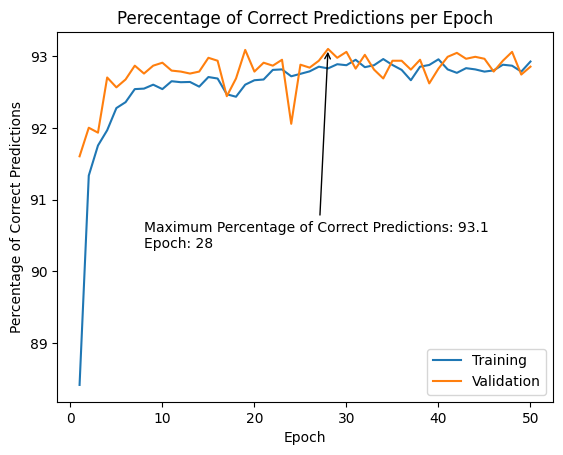

In [ ]:
import keras
from matplotlib import pyplot as plt
# plt.plot([i * 100 for i in history.history['accuracy']])
# plt.plot([i * 100 for i in history.history['val_accuracy']])

fig, ax = plt.subplots()
x = list(range(1,51))
ax.plot(x, [i * 100 for i in history.history['accuracy']]
)
ax.plot(x, [i * 100 for i in history.history['val_accuracy']]
)

# Find the maximum value and its index
ymax = np.max([i * 100 for i in history.history['val_accuracy']])
imax = np.argmax([i * 100 for i in history.history['val_accuracy']])

# Annotate the maximum value
ax.annotate(f'Maximum Percentage of Correct Predictions: {round(ymax,2)} \nEpoch: {x[imax]}\n', 
            xy=(x[imax], ymax), xytext=(x[imax]-20, ymax-3),
            arrowprops=dict(facecolor='black', arrowstyle='->'))

plt.title('Perecentage of Correct Predictions per Epoch')
plt.ylabel('Percentage of Correct Predictions')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')

plt.show()

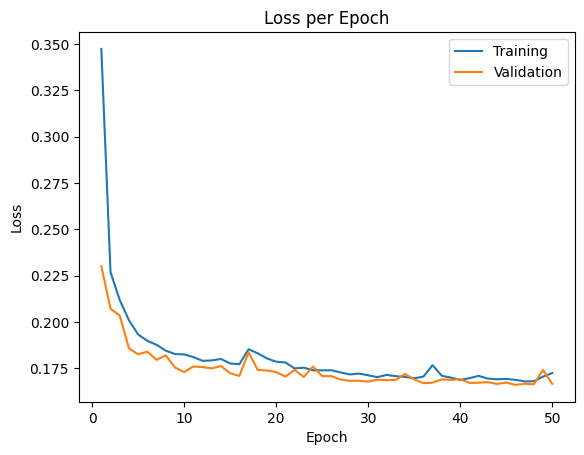

In [ ]:
fig, ax = plt.subplots()
x = list(range(1,51))
ax.plot(x, history.history['loss'])
ax.plot(x, history.history['val_loss'])

plt.title('Loss per Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.show()

##Section 5: Evaluation and Conformance Checking

###5.0 Evaluation functions

In [39]:
# calculate percentage of correct predictions
def evaluate(predictions, verbose=False):
  correct = 0 
  incorrect = 0
  for i in range(len(test_targets)):
    prediction = decode_activity.get(str(np.argmax(predictions[i])))
    if prediction == test_targets[i]:
      correct += 1
    else:
      if verbose:
        print(f"predicted : {prediction}; expected : {test_targets[i]}")
      incorrect += 1


  accuracy = correct/(correct + incorrect)
  return accuracy

In [40]:
def categoricalConfusionMatrix(predictions):
 activities = list(decode_activity.values())
 for activity in activities:
  #  initialise true and false positives and negatives
   tp, tn, fp, fn = 0,0,0,0
   activity_value = encode_activity.get(activity)
   for i in range(len(test_targets)):
     prediction = np.argmax(predictions[i])

     if int(test_targets[i]) == int(activity_value):
       #  true positive
       if int(prediction) == int(test_targets[i]):
         tp += 1
       # false negative
       else:
         fn += 1
     else:
       if int(prediction) == int(test_targets[i]):
         tn +=1
       else:
         fp +=1

   print(f'{activity}:\n true positives: {tp}\n false positives: {fp}\n true negatives: {tn}\n false negatives: {fn}')
   try:
    recall = tp/(tp+fn)
    precision = tp/(tp+fp)
    f1 = 2*(precision * recall)/(precision+recall)
   except ZeroDivisionError as e:
     print(e)  
   print(f'recall = {recall}\n precision = {precision}\n f1 score = {f1}')

###5.1 Original Models

In [41]:
# prefix-LSTM
predictions_prefix = prefix_LSTM.predict(test_x[0])
evaluate(predictions_prefix)

48/48 [==============================] - 0s 4ms/step


0.7790237467018469

In [42]:
# suffix-LSTM
predictions_suffix = suffix_LSTM.predict(test_x[1])
evaluate(predictions_suffix)

48/48 [==============================] - 0s 4ms/step


0.8337730870712401

In [43]:
# averaging outputs
predictions = []
for p in zip(predictions_prefix, predictions_suffix):
 
  arr = []
  for i in range(0,4):
    arr.append((p[0][i]+p[1][i])/2)
  predictions += [arr]

predictions = np.array(predictions)

evaluate(predictions)

0.45910290237467016

In [44]:
# bi-LSTM with activities
predictions_bi = bi_LSTM.predict([test_x[0], test_x[1]])
evaluate(predictions_bi)

48/48 [==============================] - 2s 4ms/step


0.9432717678100264

In [45]:
# bi-LSTM with time deltas
predictions_td = td_LSTM.predict([test_x[2], test_x[3]])
evaluate(predictions_td)


48/48 [==============================] - 2s 4ms/step


0.933377308707124

In [46]:
# bi-LSTM with activities and time deltas 1
predictions_bi_td = bi_LSTM_td.predict([test_x[0], test_x[1], test_x[2], test_x[3]])
evaluate(predictions_bi_td)

48/48 [==============================] - 2s 4ms/step


0.9366754617414248

In [47]:
# bi-LSTM with activities and time deltas 2
predictions_bi_td_2 = bi_LSTM_td_2.predict([test_x[0], test_x[1], test_x[2], test_x[3]])
evaluate(predictions_bi_td_2,verbose=False)

48/48 [==============================] - 3s 5ms/step


0.9478891820580475

###5.2 Best Model

In [ ]:
# bi-LSTM with activities and time deltas 2
predictions_best_model = best_model.predict([test_x[0], test_x[1], test_x[2], test_x[3]])
evaluate(predictions_best_model,verbose=True)

48/48 [==============================] - 3s 5ms/step
predicted : IV; expected : Ventilation
predicted : IV; expected : Ventilation
predicted : IV; expected : Ventilation
predicted : IV; expected : Ventilation
predicted : IV; expected : Ventilation
predicted : IV; expected : Ventilation
predicted : IV; expected : Ventilation
predicted : IV; expected : Ventilation
predicted : IV; expected : Ventilation
predicted : IV; expected : Ventilation
predicted : IV; expected : Ventilation
predicted : IV; expected : Ventilation
predicted : IV; expected : Ventilation
predicted : Ventilation; expected : Entered ICU
predicted : IV; expected : Ventilation
predicted : IV; expected : Ventilation
predicted : IV; expected : Ventilation
predicted : IV; expected : Ventilation
predicted : IV; expected : Ventilation
predicted : IV; expected : Ventilation
predicted : IV; expected : Ventilation
predicted : IV; expected : Ventilation
predicted : IV; expected : Ventilation
predicted : IV; expected : Ventilation
pr

0.9610561056105611

In [ ]:
categoricalConfusionMatrix(predictions_best_model)

ValueError: ignored

In [ ]:
predicted_labels = [decode_activity.get(str(np.argmax(i))) for i in predictions_best_model]

In [ ]:
len(predicted_labels)

1515

In [ ]:
def split_missing_complete(el):
  missing = el.loc[el['activity'].isnull()]
  complete = el.loc[el['activity'].notnull()]
  return missing, complete

In [ ]:
missing_rows, complete_rows = split_missing_complete(test_el)
missing_rows['activity'] = predicted_labels 
repaired_log = pd.concat([missing_rows, complete_rows])
repaired_log

<ipython-input-62-9d43e0f70cea>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_rows['activity'] = predicted_labels


,trace,activity,timestamp,patient,case:concept:name,concept:name,time:timestamp,@@index,@@case_index,start_timestamp
134,20,IV,2109-06-06 16:00:00,100094,100094,IV,2109-06-06 16:00:00,134.0,20.0,2109-06-06 16:00:00
240,33,Left ICU,2115-01-22 17:57:26,100146,100146,Left ICU,2115-01-22 17:57:26,240.0,35.0,2115-01-22 17:57:26
337,50,Admitted,2146-12-22 21:02:00,100225,100225,Admitted,2146-12-22 21:02:00,337.0,52.0,2146-12-22 21:02:00
357,53,Left ICU,2102-04-23 21:30:32,100263,100263,Left ICU,2102-04-23 21:30:32,357.0,55.0,2102-04-23 21:30:32
402,61,IV,2201-04-30 20:49:00,100320,100320,Ventilation,2201-04-30 20:49:00,402.0,64.0,2201-04-30 20:49:00
...,...,...,...,...,...,...,...,...,...,...
127130,17212,Left ICU,2197-01-13 10:15:00,199882,199882,Left ICU,2197-01-13 10:15:00,127130.0,20669.0,2197-01-13 10:15:00
127131,17212,Discharged,2197-01-19 15:20:00,199882,199882,Discharged,2197-01-19 15:20:00,127131.0,20669.0,2197-01-19 15:20:00
127205,17225,Admitted,2183-03-24 03:13:00,199941,199941,Admitted,2183-03-24 03:13:00,127205.0,20684.0,2183-03-24 03:13:00
127207,17225,Left ICU,2183-03-27 14:28:43,199941,199941,Left ICU,2183-03-27 14:28:43,127207.0,20684.0,2183-03-27 14:28:43


In [ ]:
def replay_trace(el, pn, im, fm):
  replay_result_alignments = pm.fitness_alignments(el, pn, im, fm, case_id_key='trace', activity_key='activity', timestamp_key='timestamp')
  return  replay_result_alignments['average_trace_fitness']

In [ ]:
replay_trace(repaired_log, net, im, fm)

aligning log, completed variants ::   0%|          | 0/282 [00:00<?, ?it/s]

0.81948925762749